In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)  # Crop to the desired output shape
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x, y = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        self.compiled_metrics.update_state(y, reconstructed_x)

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d[0][0]']          
                                                                                            

In [2]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(features, labels, test_size=0.2, random_state=42)

y_train_labels = y_train
y_test_labels = y_test

#print(x_train)
#print(x_test)
#print(y_train)
#print(y_test)

# Convert columns to NumPy arrays
x_train_features = x_train.values
x_test_features = x_test.values

# Apply scaling to the features
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

#print(x_train)
#print(x_test)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [3]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, batch_size=128, epochs=5, validation_data=(x_test, y_test))
#vae.fit(x_train, batch_size=128, epochs=5, validation_data=(x_test, y_test, None))
#vae.fit(x_train, batch_size=128, epochs=5)

Epoch 1/20
66/66 [==============================] - 3s 19ms/step - loss: 1.5535 - reconstruction_loss: 1.3882 - kl_loss: 0.0017 - val_total_loss: 1.1097 - val_reconstruction_loss: 1.1080 - val_kl_loss: 0.0017
Epoch 2/20
66/66 [==============================] - 1s 14ms/step - loss: 1.0884 - reconstruction_loss: 1.0655 - kl_loss: 0.0024 - val_total_loss: 0.9454 - val_reconstruction_loss: 0.9434 - val_kl_loss: 0.0020
Epoch 3/20
66/66 [==============================] - 1s 15ms/step - loss: 1.0135 - reconstruction_loss: 1.0004 - kl_loss: 0.0014 - val_total_loss: 0.9029 - val_reconstruction_loss: 0.9016 - val_kl_loss: 0.0013
Epoch 4/20
66/66 [==============================] - 1s 14ms/step - loss: 0.9936 - reconstruction_loss: 0.9850 - kl_loss: 7.3008e-04 - val_total_loss: 0.9065 - val_reconstruction_loss: 0.9059 - val_kl_loss: 6.3891e-04
Epoch 5/20
66/66 [==============================] - 1s 14ms/step - loss: 0.9720 - reconstruction_loss: 0.9767 - kl_loss: 4.5488e-04 - val_total_loss: 0.9022

In [4]:
#print(x_test.shape)
#print(y_test.shape)

validation_loss = vae.evaluate(x_test, y_test)
print("Validation Loss:", validation_loss)


66/66 [==============================] - 0s 2ms/step - total_loss: 0.9138 - reconstruction_loss: 0.9138 - kl_loss: 5.8065e-05
Validation Loss: [0.9138163328170776, 0.9137582778930664, 5.8064859331352636e-05]


66/66 [==============================] - 0s 1ms/step


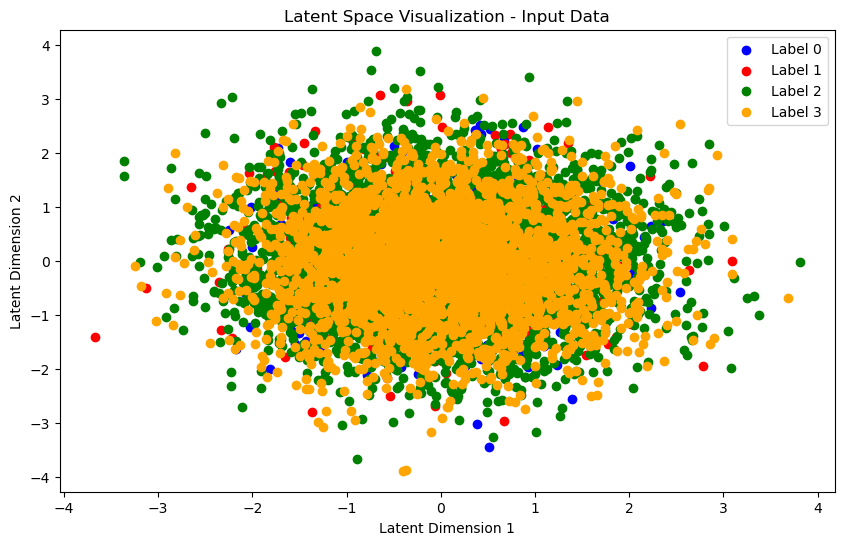

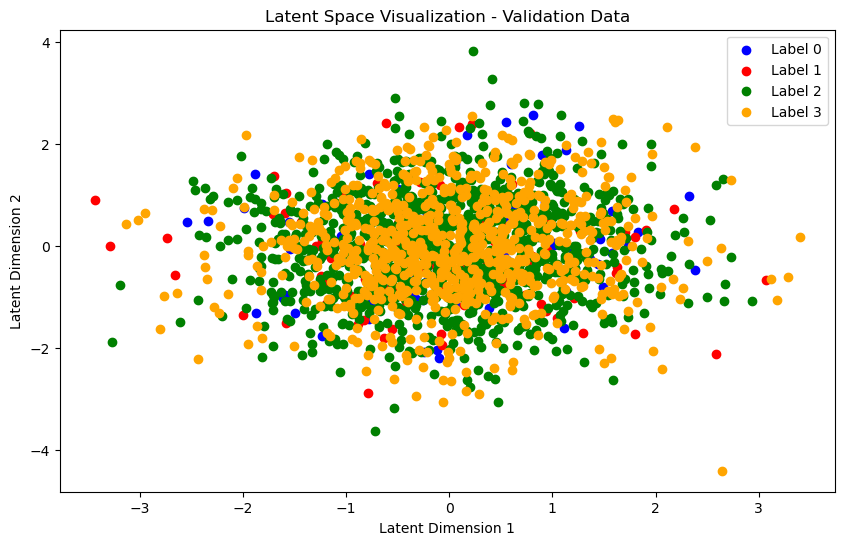

In [5]:
import matplotlib.pyplot as plt

# encode data into the latent space
_, _, encoded_x_train = vae.encoder.predict(x_train)
_, _, encoded_x_test = vae.encoder.predict(x_test)

label_colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

# input data
plt.figure(figsize=(10, 6))
for label in range(4):
    indices_train = np.where(y_train == label)[0]
    plt.scatter(encoded_x_train[indices_train, 0], encoded_x_train[indices_train, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Latent Space Visualization - Input Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()

# validation data
plt.figure(figsize=(10, 6))
for label in range(4):
    indices_test = np.where(y_test == label)[0]
    plt.scatter(encoded_x_test[indices_test, 0], encoded_x_test[indices_test, 1], c=label_colors[label],
                label='Label {}'.format(label))
plt.title('Latent Space Visualization - Validation Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.show()



66/66 [==============================] - 0s 2ms/step


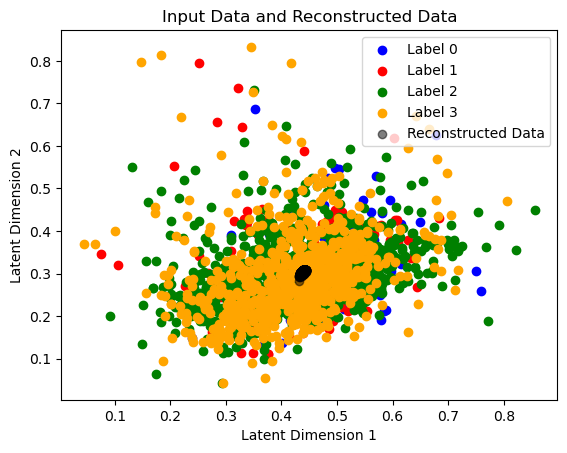

In [11]:
def plot_input_and_reconstructed_data(x_data, y_data, reconstructed_data):
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(x_data[indices, 0], x_data[indices, 1], c=label_colors[label], label=f'Label {label}')
    
    plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c='black', alpha=0.5, label='Reconstructed Data')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Input Data and Reconstructed Data")
    plt.legend()
    plt.show()

reconstructed_x_test = vae.decoder.predict(encoded_x_test)
    
plot_input_and_reconstructed_data(x_test, y_test, reconstructed_x_test)
    

In [ ]:
import matplotlib.pyplot as plt

def plot_input_data(encoder, x_data, y_data):
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(x_data[indices, 0], x_data[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Input Data")
    plt.legend()
    plt.show()

def plot_reconstructed_data(encoder, decoder, x_data, y_data):
    _, _, z = encoder.predict(x_data)
    reconstructed_data = decoder.predict(z)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']  # Specify colors for each label
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(reconstructed_data[indices, 0], reconstructed_data[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Reconstructed Data")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plot_input_data(encoder, x_train, y_train) 

plt.figure(figsize=(10, 6))
plot_reconstructed_data(encoder, decoder, x_test, y_test)